# Let's design an LSTM time series model 

In [139]:
# Import requires dependencies 
import torch
import torch.nn as nn


In [140]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Creating Dummy data

In [141]:
# Import necessaries libries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Generate sine wave dataset
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, num_samples * 0.1, num_samples, dtype=np.float32)
    y = np.sin(x)  # Sine wave
    sequences, targets = [], []
    
    for i in range(len(y) - seq_length):
        sequences.append(y[i:i+seq_length])  # Input sequence
        targets.append(y[i+seq_length])     # Target value (next step)
    
    return np.array(sequences), np.array(targets)

# Custom PyTorch Dataset
class SineWaveDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Parameters
seq_length = 50
num_samples = 1000

# Generate data
sequences, targets = generate_sine_wave(seq_length, num_samples)
sequences[:2], targets[:2]

(array([[ 0.        ,  0.09993301,  0.19886553,  0.2958071 ,  0.3897871 ,
          0.47986472,  0.56513804,  0.64475346,  0.7179138 ,  0.7838866 ,
          0.8420114 ,  0.8917063 ,  0.93247366,  0.96390545,  0.98568696,
          0.9976001 ,  0.99952555,  0.9914441 ,  0.97343665,  0.9456835 ,
          0.90846246,  0.86214626,  0.80719835,  0.74416924,  0.6736897 ,
          0.59646547,  0.5132694 ,  0.42493483,  0.33234596,  0.23642978,
          0.13814631,  0.03847999, -0.06157158, -0.16100672, -0.25883013,
         -0.354062  , -0.44574913, -0.5329735 , -0.6148622 , -0.6905949 ,
         -0.7594136 , -0.8206293 , -0.87362915, -0.9178825 , -0.95294654,
         -0.9784698 , -0.9941969 , -0.9999705 , -0.9957327 , -0.98152596],
        [ 0.09993301,  0.19886553,  0.2958071 ,  0.3897871 ,  0.47986472,
          0.56513804,  0.64475346,  0.7179138 ,  0.7838866 ,  0.8420114 ,
          0.8917063 ,  0.93247366,  0.96390545,  0.98568696,  0.9976001 ,
          0.99952555,  0.9914441 ,  0

In [142]:
sequences.shape, targets.shape

((950, 50), (950,))

In [143]:
sequences.ndim, targets.ndim

(2, 1)

# Data split with train and test

In [144]:
from sklearn.model_selection import train_test_split
train_squences, test_squences, train_targets, test_targets = train_test_split(sequences,
                                                                              targets,
                                                                              test_size=0.2,
                                                                              random_state=24
)
len(train_squences), len(test_squences), len(train_targets), len(test_targets)

(760, 190, 760, 190)

# Create pytorch dataset and dataloader

In [145]:
# Create Pytorch datasets and dataloaders
train_dataset = SineWaveDataset(train_squences, train_targets)
test_dataset = SineWaveDataset(test_squences, test_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(24, 6)

# Build LSTM model


In [146]:
# Basic libries of pytorch
import torch
import torch.nn as nn

# LSTM Model subclassing nn.Module
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass through the fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
model_0 = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

print(model_0)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


# Training and Evaluation

## Loss and optimizer

In [147]:
# loss function
loss_fn = nn.MSELoss()

# Optimizer 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr= 0.001)

In [148]:
# Training loop
def train_step(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model_0(inputs)
            loss = loss_fn(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

train_step(model=model_0, train_loader=train_dataloader, num_epochs=10)


Epoch [1/10], Loss: 0.2655
Epoch [2/10], Loss: 0.0251
Epoch [3/10], Loss: 0.0056
Epoch [4/10], Loss: 0.0011
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0000


In [149]:
# Testing loop
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model_0(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    return np.array(predictions), np.array(actuals)

In [150]:
predictions, actuals = evaluate_model(model_0, test_dataloader, device=device)
predictions[:5], actuals[:5]

(array([[-0.95095414],
        [ 0.30226302],
        [-0.9973131 ],
        [ 0.98551303],
        [ 0.5155162 ]], dtype=float32),
 array([[-0.9504821 ],
        [ 0.31018972],
        [-0.99953383],
        [ 0.9989466 ],
        [ 0.5199076 ]], dtype=float32))

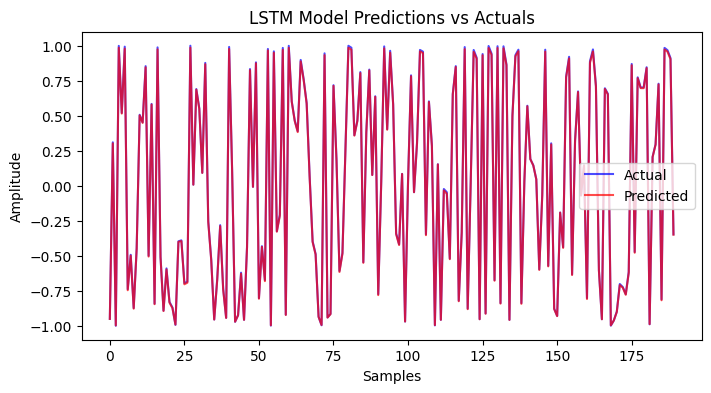

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(actuals, label="Actual", color='blue', alpha=0.7)
plt.plot(predictions, label="Predicted", color='red', alpha=0.7)
plt.title("LSTM Model Predictions vs Actuals")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [152]:
import torch

# Set the model to evaluation mode
model_0.eval()

# Create a manual input sequence (e.g., a sine wave or any meaningful sequence)
manual_input = np.sin(np.linspace(0, 5, 50, dtype=np.float32))  # Replace with your own sequence
manual_input = torch.tensor(manual_input).unsqueeze(0).unsqueeze(-1).to(device)  # Shape: (1, seq_length, 1)

# Predict the next value
with torch.inference_mode():
    prediction = model_0(manual_input)

# Print the result
print(f"Manual Input: {manual_input.cpu().numpy().flatten()}")
print(f"Predicted Next Value: {prediction.item()}")

Manual Input: [ 0.          0.10186383  0.20266794  0.30136365  0.39692417  0.48835534
  0.574706    0.65507793  0.72863483  0.79461145  0.85232157  0.9011647
  0.94063276  0.97031516  0.9899031   0.9991927   0.99808747  0.98659885
  0.9648463   0.9330562   0.89155924  0.8407871   0.78126806  0.71362114
  0.63855034  0.5568365   0.46932968  0.3769401   0.28062934  0.18139909
  0.0802817  -0.02167088 -0.12339825 -0.22384164 -0.32195634 -0.4167216
 -0.5071516  -0.5923058  -0.6712978  -0.74330616 -0.80758166 -0.86345565
 -0.91034687 -0.9477675  -0.9753282  -0.9927424  -0.9998287  -0.9965134
 -0.9828312  -0.9589243 ]
Predicted Next Value: -0.9346393346786499


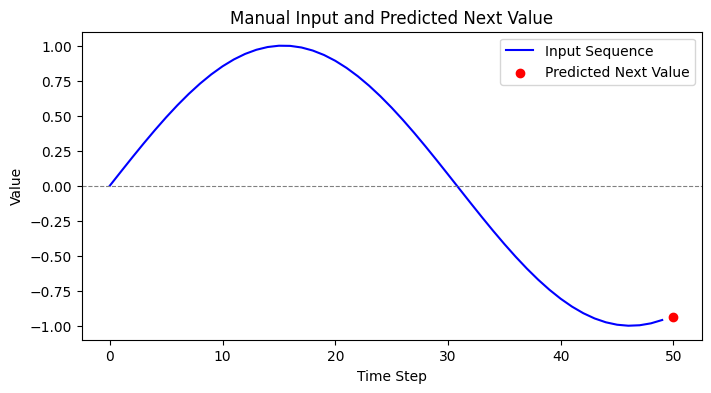

In [153]:
import matplotlib.pyplot as plt

# Convert tensors back to numpy for visualization
manual_input_np = manual_input.cpu().numpy().flatten()
predicted_next = prediction.item()

# Extend the input sequence with the predicted value
extended_sequence = np.append(manual_input_np, predicted_next)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(len(manual_input_np)), manual_input_np, label="Input Sequence", color="blue")
plt.scatter(len(manual_input_np), predicted_next, color="red", label="Predicted Next Value")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Manual Input and Predicted Next Value")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()
